# Chapter 3: Interpolation and Curve Fitting

## Introduction

Let's consider a set of $n$ discrete data points, here in 2D:


| $x_0$ | $x_1$ | $x_2$ | $\ldots$ | $x_n$ |
|----|:----:|:----:|:-------:|----:|
| $y_0$ | $y_1$ | $y_2$ | $\ldots$ | $y_n$ |

For instance, let's generate and plot $n$ random data points:

In [11]:
from numpy import array, arange, zeros
from random import random

def get_random_points(n):
    '''
    Generates n points where x[i] = i and y[i]
    is a random number between 0 and 1.
    '''
    x = arange(n)
    y = zeros(n)
    for i in range(n):
        y[i] = random()
    return x, y

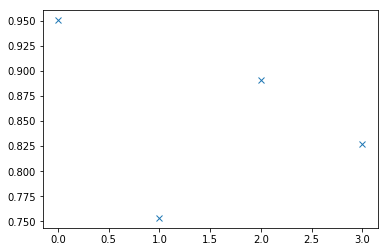

In [145]:
import matplotlib.pyplot as plt

n = 4
x, y = get_random_points(n)
plt.plot(x, y, 'x')
plt.show()

### Interpolation

Consists in finding a function $f$ that passes through $(x_i, y_i)$: $\forall i \in |[0, n]|, \quad y_i = f(x_i)$.

We will study two types of interpolation functions:
1. Polynomial interpolation
2. Cubic-spline interpolation

Example: polynomial interpolation with Scipy:

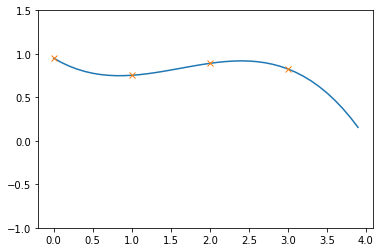

In [146]:
from scipy.interpolate import lagrange # new module: scipy. Works with numpy arrays!
poly = lagrange(x, y)
xfine = arange(0, n, 0.1)
plt.plot(xfine, poly(xfine), "-", x, y, "x")
plt.ylim((-1,1.5))
plt.show()

**Be careful** with oscillations and extrapolation, when $n$ increases.

Example: cubic spline interpolation with Scipy:

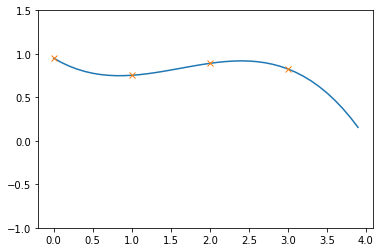

In [147]:
from scipy.interpolate import CubicSpline # that's a class
spline = CubicSpline(x, y)
plt.plot(xfine, spline(xfine), "-", x, y, "x")
plt.ylim((-1, 1.5))
plt.show()

### Curve fitting

Consists in finding a function $f$ that approximates $(x_i, y_i)$. In particular, least-square fitting finds $f$ such that:
$$
\sum_{i=o}^n\left(y_i - f(x_i)\right)^2
$$
is minimal.

Example: f is a straight line.

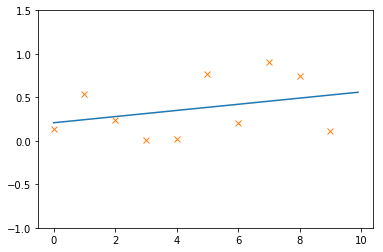

In [75]:
from numpy import polyfit, polyval
line = polyfit(x, y, 1)
plt.plot(xfine, polyval(line, xfine), '-', x, y, 'x')
plt.ylim((-1, 1.5))
plt.show()

Example: f is a degree 3 polynomial

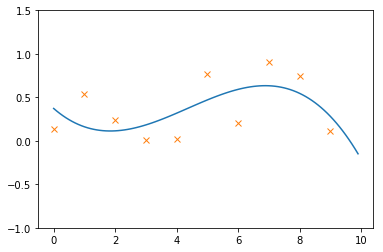

In [76]:
from numpy import polyfit, polyval
poly3 = polyfit(x, y, 3)
plt.plot(xfine, polyval(poly3, xfine), '-', x, y, 'x')
plt.ylim((-1, 1.5))
plt.show()

## Polynomial Interpolation

There is one and only one polynomial $P_n$ of degree $n$ that passes through $n+1$ distinct points. 

This polynomial can be constructed in different ways. Here we will look at:
1. Lagrange method
2. Newton method

### Lagrange method

Lagrange method expresses $P_n$ as follows:
$$
P_n(x) = \sum_{i=0}^n y_i l_i(x)
$$
where $\forall i \in |[0, n]|$:
* $l_i$ is a polynomial of degree n
* $l_i(x_i)$ = 1
* $l_i(x_j)$ = 0, $\quad \forall j \neq i$


The Lagrange polynomials are expressed as follows:

$$
\forall i \in |[0, n]|, \quad l_i(x) = \prod_{j=0 \\ j \neq i}^n \frac{x-x_j}{x_i-x_j}
$$
(Warning: typo in the expression of $l_i$ in the textbook)

For instance, with n=2:

$$
l_0(x) = \frac{(x-x_1)(x-x_2)}{(x_0-x_1)(x_0-x_2)} \quad
l_1(x) = \frac{(x-x_0)(x-x_2)}{(x_1-x_0)(x_1-x_2)} \quad
l_2(x) = \frac{(x-x_0)(x-x_1)}{(x_2-x_0)(x_2-x_1)}
$$

Illustration:

In [93]:
def lagrange_poly(x_data, i):
    def l_i(x):
        p = 1
        for j in range(len(x_data)):
            if j == i:
                continue
            p *= (x-x_data[j])/(x_data[i]-x_data[j])
        return p
    return l_i # watch out, we're returning a function here!

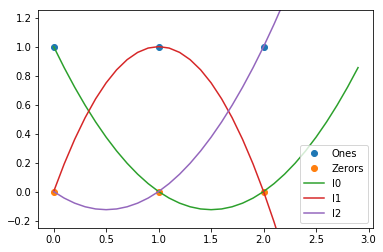

In [119]:
from matplotlib import pyplot as plt
from numpy import zeros, ones

n = 3
x_data = range(n)
x_data_fine = arange(0, n, 0.1)
l_0 = lagrange_poly(x_data, 0)
plt.ylim((-0.25, 1.25))
plt.plot(x_data, ones(n), 'o', x_data, zeros(n), 'o')
legend = ['Ones', 'Zerors']
for i in range(n):
    l_i = lagrange_poly(x_data, i)
    plt.plot(x_data_fine, l_i(x_data_fine), '-')
    legend.append("l"+str(i))
plt.legend(legend)

In [132]:
def interpol_lagrange(x_data, y_data, x):
    '''
        Returns the value of P_n at x, computed with Lagrange's method
    '''
    n = len(x_data)
    assert(n==len(y_data))
    polynomials = []
    # Note: if this function is going to be used repeatedly
    # for different values of x, we should store and reuse
    # the polynomials
    for i in range(n):
        polynomials.append(lagrange_poly(x_data, i))
    s = 0
    for i in range(n):
        s += polynomials[i](x)*y_data[i]
    return s

### Error in x

It can be shown that:

$$
\forall x \in \mathbb{R}, \quad \exists \xi \in [x_0, x_n], \quad f(x) - P_n(x) = \frac{(x-x_0)(x-x_1)\ldots(x-x_n)}{(n+1)!}f^{(n+1)}(\xi)
$$

This can be used to find an upper bound of the interpolation error, as shown in the example below.

#### Example

(from E. Doedel's lecture notes)
$$
n = 2, \quad f(x) = e^x, \quad x_0=0, \quad x_1=1, \quad x_2=2
$$

$f^{n+1}(x)=f^3(x)=e^x$.

Let's estimate the error for $x=1.5$:

$$
\exists \xi \in [0, 2], \quad f(x) - P_n(x) = \frac{1.5 \times 0.5 \times -0.5}{3 \times 2}e^{\xi}
$$

$$
\Rightarrow f(x) - P(x) \leq \frac{3}{48}e^2 \approx 0.4618
$$

The actual error is:

In [140]:
from math import exp
x = 1.5
#interpol_lagrange([0, 1, 2], [exp(0), exp(1), exp(2)], 1.5)
abs(exp(x) - interpol_lagrange([0, 1, 2],
                               [exp(0), exp(1), exp(2)],
                               x))

0.20291833810521265

## Newton method

The Newton method provides a better algorithm for polynomial interpolation.

Here, $P_n$ is written as follows:

$$
P_n(x) = a_0 + (x-x_0)a_1 + (x-x_0)(x-x_1)a_2 + \ldots + (x-x_0)(x-x_1)\ldots(x-x_{n-1})a_n
$$

which can be transformed to:

$$
P_n(x) = a_0 + (x-x_0)\left[ a_1 + (x-x_1)\left[a_2 + (x-x_2)\left[a_3 + ... \left[a_{n-1} + (x-x_{n-1})a_n \right] \right] \right]\right]
$$

This can be evaluated through the following recurrence relation: 
$$
P_0(x) = a_n \quad \mathrm{and} \quad \forall k \in |[1, n]|, \quad P_k(x) = a_k + (x-x_{n-k})P_{k-1}(x)
$$

**Once the a_i are known**, the polynomial can be computed as follows:

In [143]:
def eval_poly_newton(a, x_data, x):
    p = a[-1] # last element in a
    for i in range(n-1, -1, -1):
        p = a[i] + (x-x_data[n-1-i])*p
    return p

The coefficients $a_i$ are determined by forcing $P_n(x_i)=y_i$ for every data point:

$$
a_0 = y_0
a_1 = \frac{y_1-a_0}{x_1-x_0} = \frac{y_1 - y_0}{x_1 - x_0}
a_2 = 
$$

## Limitations of Polynomial interpolation

When the number of data points increases:
* Polynomials tend to oscillate between points, increasing the error between data points.
* Extrapolation is very dangerous, as high-order polynomials vary rapidly.

Illustration:

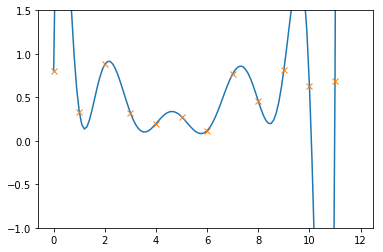

In [155]:
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange

n = 12
x, y = get_random_points(n)
poly = lagrange(x, y)
xfine = arange(0, n, 0.1)
plt.plot(xfine, poly(xfine), "-", x, y, "x")
plt.ylim((-1,1.5))
plt.show()

## Interpolation with Cubic Spline

Cubic Spline are better suited than Polynomials when there are many data points. 

### Mechanical interpretation

Cubic Splines model an elastic beam bended by pins located at data points:

### Expression

Cubic Splines are defined piecewise, on intervals defined by the abscissa of the data points:

On $[x_i, x_{i+1}]$ (i < n), a Cubic Spline is defined by a degree-3 polynomial $f_i$, such that:

$$
f_i^{''}(x_{i+1}) = f_{i+1}^{''}(x_{i+1})
$$
